# Tutorial 2: Hair follicle (ATAC-seq + RNA-seq)

This tutorial investigates a multimodal single-cell hair follicle dataset by [Ma et al., 2020](https://www.sciencedirect.com/science/article/pii/S0092867420312538). Data comes from female mouse dorsal skin and consists of two single-cell modalities: ATAC-seq (chromatin accessibility, raw data available on [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156597)) and RNA-seq (gene expression, raw data available on [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156608)).

In Tutorial 1, you visualized MDM components with both ForceAtlas2 and UMAP. Ocelli implements an extended force-directed layout approach that uses transition probabilities (velocities) between cells. There are a few methods modeling transition probabilities between cells, such as [Velocyto](https://doi.org/10.1038/s41586-018-0414-6), [scVelo](https://www.nature.com/articles/s41587-020-0591-3), or [Waddington Optimal Transport](https://www.sciencedirect.com/science/article/pii/S009286741930039X). In this tutorial, you will construct the MDM embedding of the hair follicle dataset and learn how to use RNA dynamics information when creating the graph for force-directed data visualization.

## Loading and preprocessing data

Download filtered data, available on [figshare](https://doi.org/10.6084/m9.figshare.22700056.v2).

In [1]:
! wget --content-disposition https://figshare.com/ndownloader/articles/22700056/versions/4
! unzip -o 22700056.zip
! rm 22700056.zip

--2023-10-04 07:06:45--  https://figshare.com/ndownloader/articles/22700056/versions/4
Resolving figshare.com (figshare.com)... 34.248.41.179, 52.31.154.4, 2a05:d018:1f4:d000:74e3:9f5a:4aed:5f8, ...
Connecting to figshare.com (figshare.com)|34.248.41.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167301210 (160M) [application/zip]
Saving to: ‘22700056.zip’

22700056.zip        100%[===================>] 159.55M  21.4MB/s    in 8.5s    

2023-10-04 07:06:55 (18.8 MB/s) - ‘22700056.zip’ saved [167301210/167301210]

Archive:  22700056.zip
 extracting: hair_follicle_atac.h5ad  
 extracting: hair_follicle_atac_peaks.h5ad  
 extracting: hair_follicle_rna.h5ad  
 extracting: hair_follicle_signature_HS_Co.csv  
 extracting: hair_follicle_signature_HS_Me.csv  
 extracting: hair_follicle_signature_IRS_He.csv  
 extracting: hair_follicle_signature_IRS_Hu.csv  


Load gene expression data. We generated the RNA-seq annotated matrix from raw BAM files with [Velocyto](https://doi.org/10.1038/s41586-018-0414-6) and then filtered cells and genes. Filtering steps are described in detail in the paper. The resulting count matrix has 7,160 cells and 6,731 genes, together with unspliced (`adata.layers['unspliced']`) and spliced (`adata.layers['spliced']`) expression layers needed for RNA velocity calculation.

In [2]:
import anndata as ad

rna = ad.read_h5ad('hair_follicle_rna.h5ad')

rna

AnnData object with n_obs × n_vars = 7160 × 6731
    obs: 'celltype', 'doublet_scores', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'X_lda_params'
    obsm: 'X_lda'
    varm: 'X_lda'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Ocelli's data preprocessing is based on topic modeling, a data compression approach that organizes features into cohesive groups (topics). Each cell is modeled as a probabilistic topic mixture, with highly-expressed topics being more probable. These distributions form highly-compressed and information-rich latent spaces on which we train models. Topic distributions are cell-normalized; therefore, no further normalization is needed.

Ocelli uses Latent Dirichlet Allocation (LDA), a generative Bayesian topic model, which has become the golden standard in the field. We run LDA on filtered count matrices, with low-quality cells/features removed. LDA has two major parameters: `n_components` (the number of topics) and `max_iter` (the maximum number of LDA's training iterations).

Compute 50 LDA topics on the RNA-seq count matrix. Downloaded data includes precomputed topics.

In [3]:
import ocelli as oci

#oci.pp.LDA(rna, n_components=50, max_iter=50, random_state=SEED, verbose=1)

Estimate RNA velocities with [scVelo](https://scvelo.readthedocs.io) on 1,000 log-normalized highly variable genes.

In [4]:
import scvelo as scv

scv.pp.normalize_per_cell(rna, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(rna, n_top_genes=1000)
scv.pp.log1p(rna)

scv.tl.velocity(rna, mode='stochastic')
scv.tl.velocity_graph(rna)

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/7160 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Load the chromatin accessibility data. We generated the ATAC-seq count matrix with [Signac](https://stuartlab.org/signac/index.html) by mapping chromatin accessibility fragments to gene regions, including the 2kb upstream. Next, we filtered low-quality genes, resulting in 17,495 genes.

In [5]:
atac = ad.read_h5ad('hair_follicle_atac.h5ad')

atac

AnnData object with n_obs × n_vars = 7160 × 17495
    uns: 'X_lda_params'
    obsm: 'X_lda'
    varm: 'X_lda'

Compute 50 LDA topics on the ATAC-seq count matrix. Downloaded data includes precomputed topics.

In [6]:
#oci.pp.LDA(atac, n_components=50, max_iter=50, random_state=17, verbose=1)

## Multimodal Diffusion Maps

Create a joint `AnnData` object for both modalities to start multimodal analysis. It must include preprocessed modality arrays saved in `adata.obsm` and a list of their keys stored in `adata.uns`. Everything else is optional.

In [7]:
from scipy.sparse import csr_matrix

# create empty AnnData object
adata = ad.AnnData(csr_matrix(([],([],[])), shape=(7160, 1000)))

# save modality arrays
adata.obsm['rna'] = rna.obsm['X_lda']
adata.obsm['atac'] = atac.obsm['X_lda']
adata.uns['modalities'] = ['rna', 'atac']

# save cell metadata
adata.obs.index = list(rna.obs.index)
adata.obs['celltype'] = list(rna.obs['celltype'])

# save RNA velocity data
adata.uns['velocity_graph'] = rna.uns['velocity_graph']
adata.uns['velocity_graph_neg'] = rna.uns['velocity_graph_neg']
adata.layers['velocity'] = rna.layers['velocity']

adata

AnnData object with n_obs × n_vars = 7160 × 1000
    obs: 'celltype'
    uns: 'modalities', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'rna', 'atac'
    layers: 'velocity'

Follow the MDM workflow: compute nearest neighbors across modalities, multimodal weights, and the low-dimensional MDM embedding.

In [8]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.weights(adata, random_state=17, verbose=True)
oci.tl.MDM(adata, n_components=20, random_state=17, save_eigvec=True, save_eigval=True, verbose=True)

[rna]	20 nearest neighbors calculated.
[atac]	20 nearest neighbors calculated.


2023-10-04 07:07:32,489	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2023-10-04 07:07:38,917	INFO worker.py:1518 -- Started a local Ray instance.


[rna]	Unimodal Markov chain calculated.
[atac]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
20 Multimodal Diffusion Maps components calculated.


## Visualizing MDM components with RNA velocity

With Ocelli, you can incorporate transition probabilities between cells (such as RNA velocities) when constructing low-dimensional embeddings. `oci.tl.transitions_graph` builds the graph for force-directed data visualization, which connects a cell to its nearest neighbors with the highest transition probabilities. If the neighborhood has too few cells with non-zero transitions, edges are created towards the nearest neighbors. You may interpret the transitions graph as follows: the MDM latent space represents a global multimodal structure, while RNA transitions align cells locally (within cells' neighborhoods) along a velocity stream.

In [9]:
oci.pp.neighbors(adata, x=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.transitions_graph(adata, x='X_mdm', transitions='velocity_graph', n_edges=3, 
                         verbose=True)

[X_mdm]	100 nearest neighbors calculated.
Transitions-based graph constructed.


Compute a 3D FLE.

In [10]:
oci.tl.FA2(adata, n_components=3, random_state=17)

Oct 04, 2023 7:07:58 AM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Oct 04, 2023 7:07:58 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 7,160 (7,160 added)
Oct 04, 2023 7:07:58 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 21,480 (20,575 added)


**********************

***25%
*************************50%
*************************75%
*************************100%
Time = 87.559s


Explore multiple 2D projections.

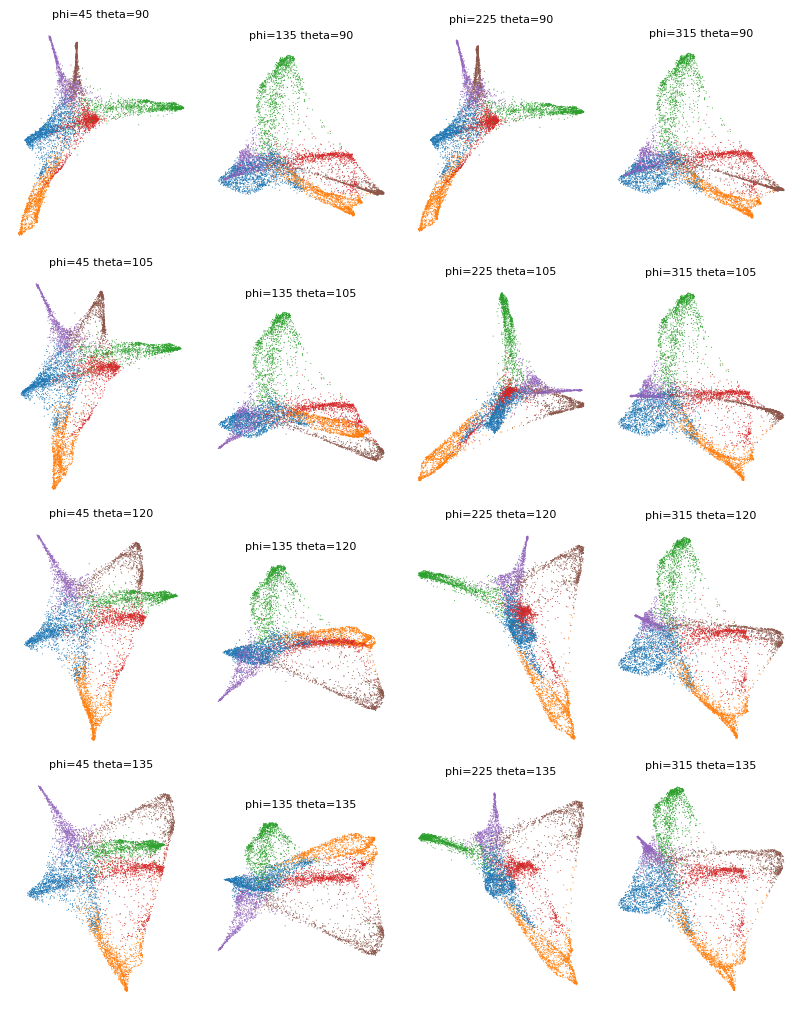

In [11]:
# specify colors for plots
cdict = {'TAC-1': '#1f77b4', 
         'IRS - Henle\'s layer': '#ff7f0e', 
         'HS - Cortex': '#2ca02c',
         'TAC-2': '#d62728',
         'IRS - Huxley\'s layer': '#9467bd', 
         'HS - Medulla': '#8c564b'}

oci.pl.projections(adata, x='X_fa2', c='celltype', phis=[45, 135, 225, 315], 
                   thetas=[90, 105, 120, 135], cdict=cdict, markersize=0.5, 
                   fontsize=8, figsize=(8, 10), showlegend=False, random_state=17)

Select a projection for further exploration: `phi=135` and `theta=135`.

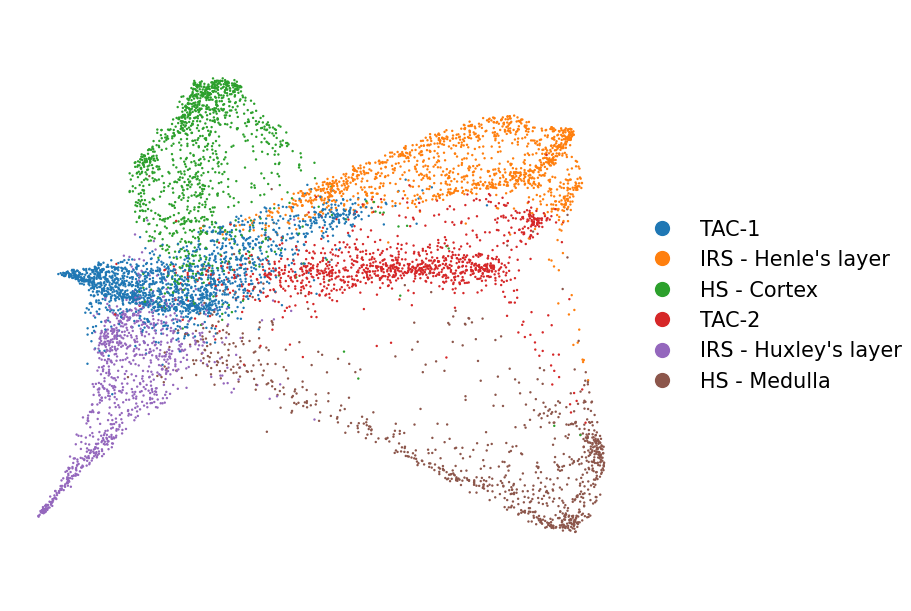

In [12]:
oci.tl.projection(adata, x='X_fa2', phi=135, theta=135, random_state=17)
oci.pl.scatter(adata, x='X_proj', c='celltype', cdict=cdict, markersize=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title='')

Validate the quality of visualization by plotting the velocity stream.

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_proj', embedded velocity vectors (adata.obsm)


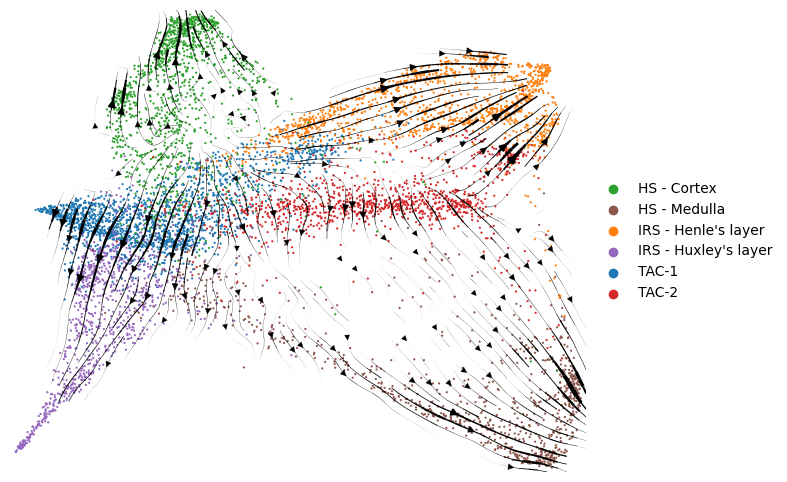

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 6))
scv.pl.velocity_embedding_stream(adata, basis='proj', alpha=1, title='', density=2,
                                 linewidth=2, show=False, ax=ax, color='celltype', 
                                 size=10, legend_fontweight=2, legend_loc='right center', 
                                 palette=cdict)

ax.set_aspect('equal')

## Interpreting multimodal weights

You can investigate multimodal weight distribution in multiple ways. For example, as in Tutorial 1, with scatter and violin plots.

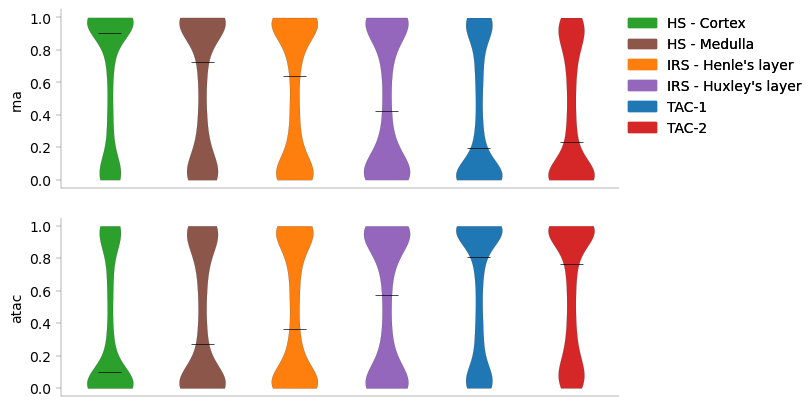

In [14]:
oci.pl.violin(adata, groups='celltype', values='weights', cdict=cdict, fontsize=10, 
              figsize=(8, 4))

Another option is bar plots which show the median or mean weight value per cell group.

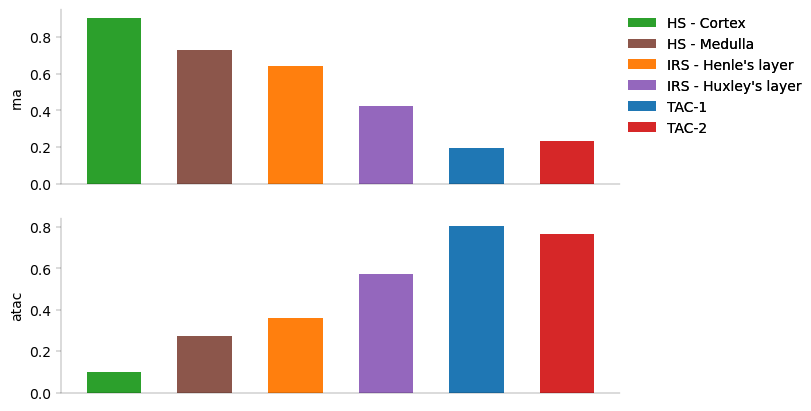

In [15]:
oci.pl.bar(adata, groups='celltype', values='weights', height='median', cdict=cdict, 
           fontsize=10, figsize=(8, 4))

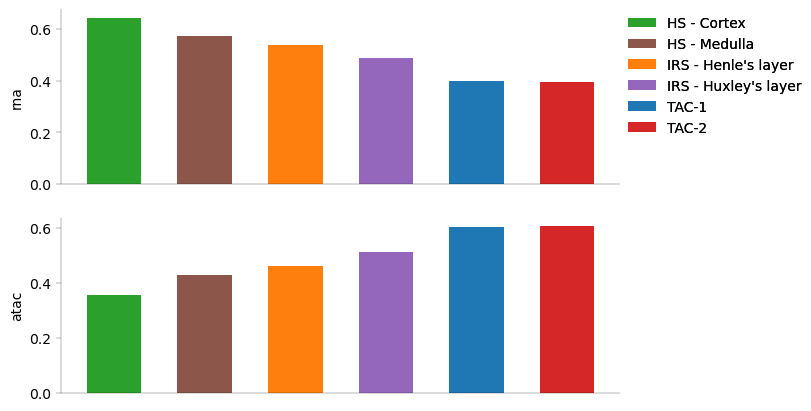

In [16]:
oci.pl.bar(adata, groups='celltype', values='weights', height='mean', cdict=cdict, 
           fontsize=10, figsize=(8, 4))

Chromatin accessibility is a more informative modality for transit-amplifying cells (TACs) and RNA-seq is more informative for later developmental stages in hair shaft (HS) and inner root sheath (IRS).

## Analyzing gene signatures

If you have unannotated cells or you wish to validate existing annotations, inspecting gene markers or gene signatures can help understand your dataset's biology. The hair follicle system was studied in detail by [Yang et al., 2017](https://www.sciencedirect.com/science/article/pii/S0092867417303677), resulting in gene signatures for HS and IRS cell subtypes.

In this section, you will examine hair follicle gene signatures with [z-scores](https://en.wikipedia.org/wiki/Standard_score), a statistic that measures how many standard deviations a value deviates from the mean. A high z-score for a cell indicates that a gene is expressed above the mean. For a gene signature, z-scores are computed for each gene individually and then averaged.

Firstly, log-normalize RNA-seq counts.

In [17]:
import scanpy as sc

rna_sig = ad.read_h5ad('hair_follicle_rna.h5ad')

sc.pp.normalize_total(rna_sig, target_sum=10000)
sc.pp.log1p(rna_sig)

`oci.tl.mean_z_scores` computes mean z-scores for a signature specified by a list of column indices of the AnnData. `get_indices` converts a list of gene names into a list of `rna_sig.var` indices.

In [18]:
def get_indices(signature, varnames):
    indices = list()

    for gene in signature:
        if gene in varnames:
            indices.append(varnames.index(gene))

    return indices

### Hair shaft (HS) gene signatures

Examine z-scores for HS gene signatures. Start with Medulla.

2023-10-04 07:09:34,487	INFO worker.py:1518 -- Started a local Ray instance.


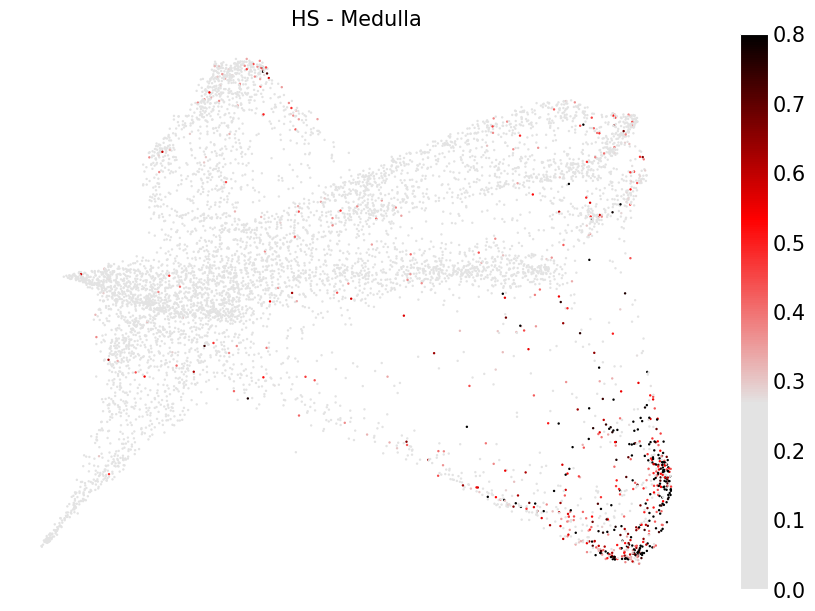

In [19]:
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

# define a custom colormap
cmap = LinearSegmentedColormap.from_list(
    'custom', ['#e3e3e3','#e3e3e3', '#ff0000', '#000000'], N=256)

# load a gene signature
markers = list(pd.read_csv('hair_follicle_signature_HS_Me.csv', index_col=0).index)

# set a gene signature name
name = 'HS - Medulla'

# save a list of all gene names
var_names = list(rna_sig.var.index)

# get marker indices
marker_indices = get_indices(markers, var_names)

# compute z-scores
oci.tl.mean_z_scores(rna_sig, markers=marker_indices, out=name)

# save z-scores to adata
adata.obs[name] = rna_sig.obs[name]

# plot z-scores
oci.pl.scatter(adata, x='X_proj', c=name, cmap=cmap, markersize=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title=name, vmin=0, vmax=0.8)

Repeat for Cortex.

2023-10-04 07:09:41,348	INFO worker.py:1518 -- Started a local Ray instance.


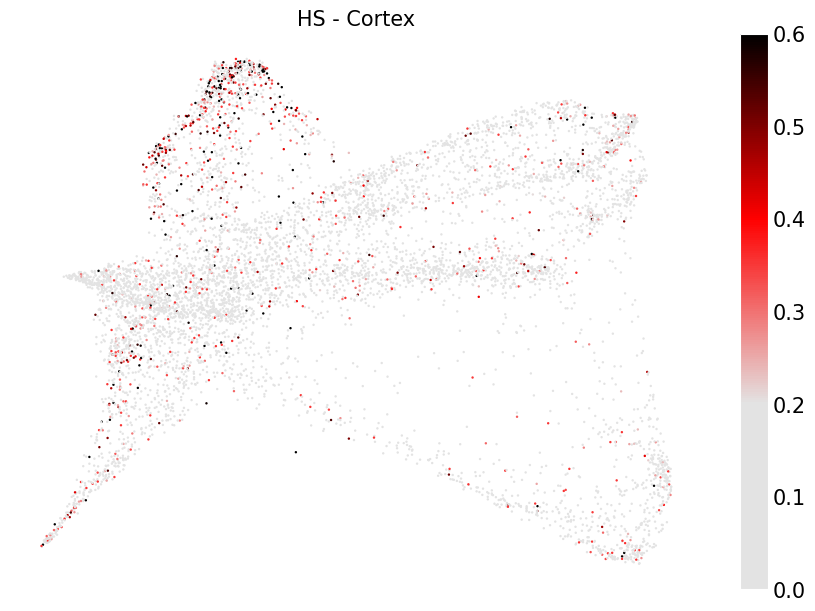

In [20]:
markers = list(pd.read_csv('hair_follicle_signature_HS_Co.csv', index_col=0).index)
name = 'HS - Cortex'
var_names = list(rna_sig.var.index)

marker_indices = get_indices(markers, var_names)
oci.tl.mean_z_scores(rna_sig, markers=marker_indices, out=name)

adata.obs[name] = rna_sig.obs[name]
oci.pl.scatter(adata, x='X_proj', c=name, cmap=cmap, markersize=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title=name, vmin=0, vmax=0.6)

### Inner root sheath (IRS) gene signatures

Repeat procedure for inner root sheath gene signatures.

2023-10-04 07:09:48,275	INFO worker.py:1518 -- Started a local Ray instance.


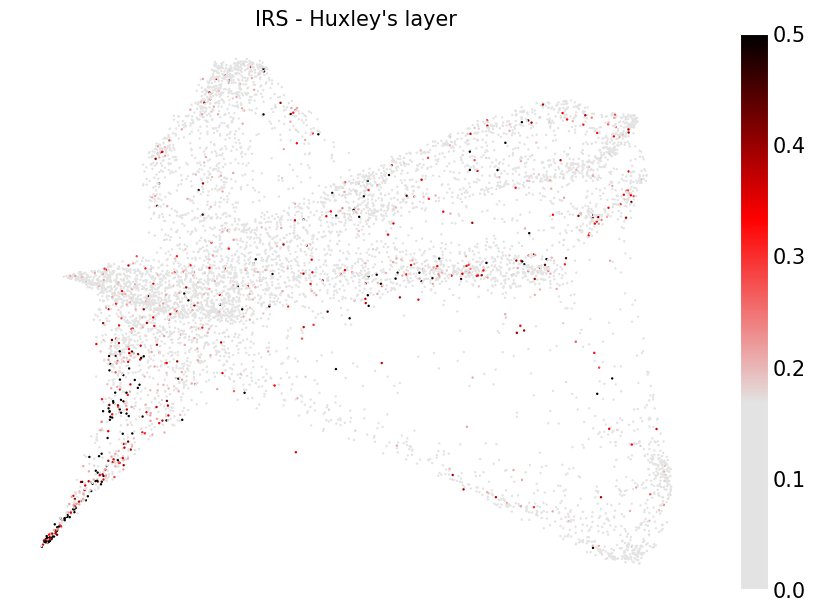

In [21]:
markers = list(pd.read_csv('hair_follicle_signature_IRS_Hu.csv', index_col=0).index)
name = 'IRS - Huxley\'s layer'
var_names = list(rna_sig.var.index)

marker_indices = get_indices(markers, var_names)
oci.tl.mean_z_scores(rna_sig, markers=marker_indices, out=name)

adata.obs[name] = rna_sig.obs[name]
oci.pl.scatter(adata, x='X_proj', c=name, cmap=cmap, markersize=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title=name, vmin=0, vmax=0.5)

2023-10-04 07:09:55,226	INFO worker.py:1518 -- Started a local Ray instance.


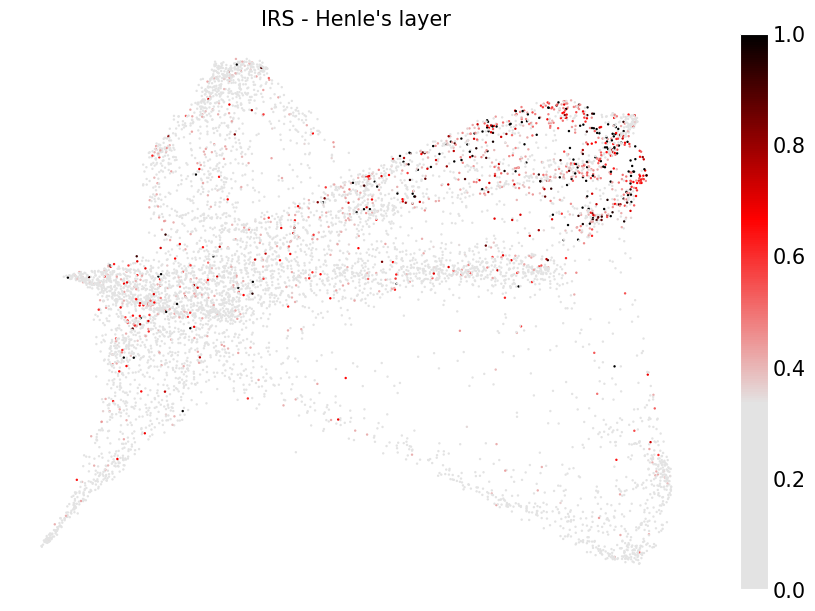

In [22]:
markers = list(pd.read_csv('hair_follicle_signature_IRS_He.csv', index_col=0).index)
name = 'IRS - Henle\'s layer'
var_names = list(rna_sig.var.index)

marker_indices = get_indices(markers, var_names)
oci.tl.mean_z_scores(rna_sig, markers=marker_indices, out=name)

adata.obs[name] = rna_sig.obs[name]
oci.pl.scatter(adata, x='X_proj', c=name, cmap=cmap, markersize=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title=name, vmin=0, vmax=1)

# Tutorial 2.1: Diffusion-based multimodal imputation

The single-cell profiling of cells inevitably generates data of high sparsity levels, resulting in 0-inflated feature values that obstruct the inference of relationships between features. This section shows how to use Ocelli to strengthen a weak single-cell signal using diffusion-based multimodal imputation. This process restores the missing expression values by exponentiation of the multimodal Markov matrix to a power $t$ and multiplying the result by the original expression matrix.

Below, you will impute values of RNA-seq gene expression and ATAC-seq promoter activity of two hair follicle's Henle's lineage markers, Krt71 and Krt73.

## Imputation of RNA-seq gene expression

Load raw RNA-seq gene expression of Krt71 and Krt73.

In [23]:
rna = ad.read_h5ad('hair_follicle_rna.h5ad')[:, ['Krt71', 'Krt73']]

# save FLE for plotting purposes
rna.obsm['X'] = adata.obsm['X_proj']

Plot the raw gene expression of Krt71.

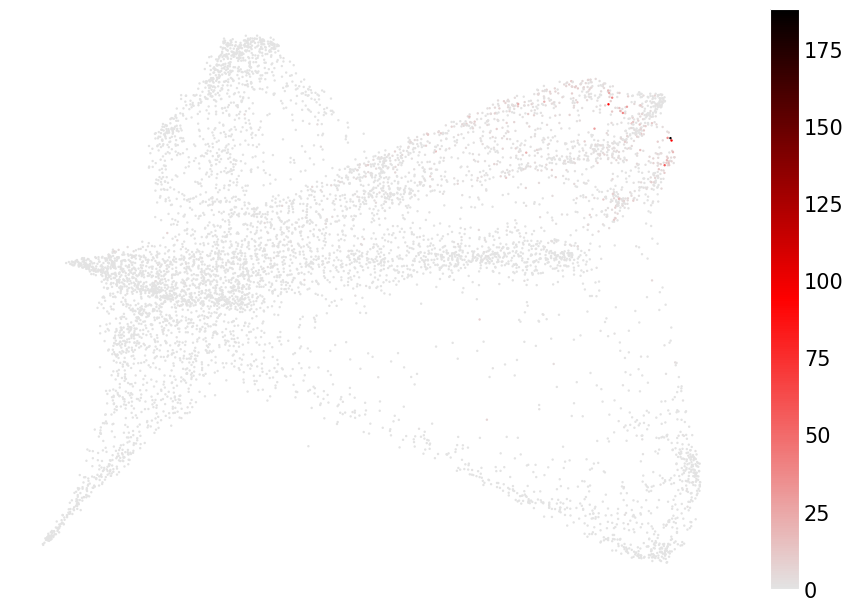

In [24]:
# define a colormap
cmap = LinearSegmentedColormap.from_list('custom', ['#e3e3e3', '#ff0000', '#000000'], N=256)

rna.obs['Krt71_t0'] = rna[:, 'Krt71'].X.toarray().flatten()

oci.pl.scatter(rna, x='X', c='Krt71_t0', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Plot the raw gene expression of Krt73.

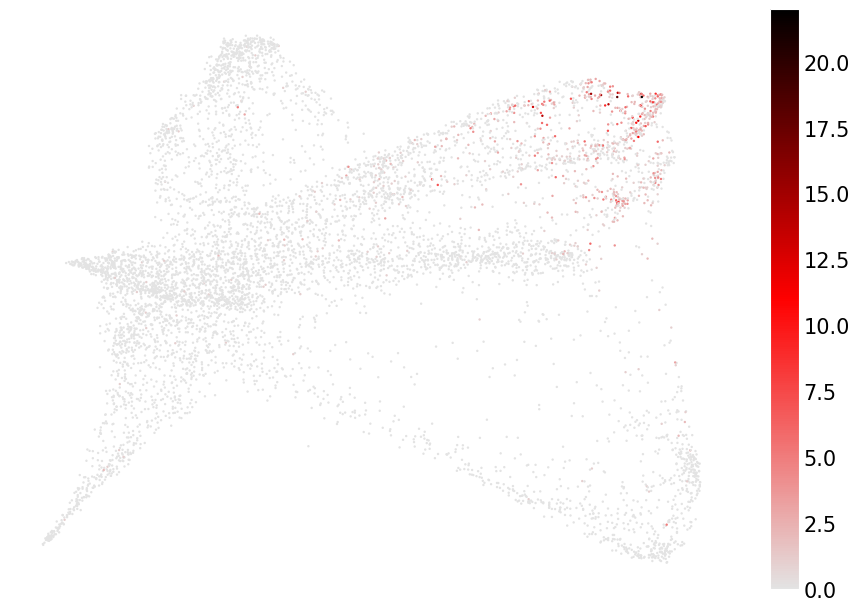

In [25]:
rna.obs['Krt73_t0'] = rna[:, 'Krt73'].X.toarray().flatten()

oci.pl.scatter(rna, x='X', c='Krt73_t0', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Diffusion-based multimodal imputation with Ocelli requires multimodal eigenvectors and their corresponding eigenvalues. Add them to the `rna` object and impute `rna.X` using MDM-generated multimodal information.

In [26]:
rna.uns['eigenvectors'] = adata.uns['eigenvectors']
rna.uns['eigenvalues'] = adata.uns['eigenvalues']

oci.tl.imputation(rna, t=1)

Plot the imputed gene expression of Krt71.

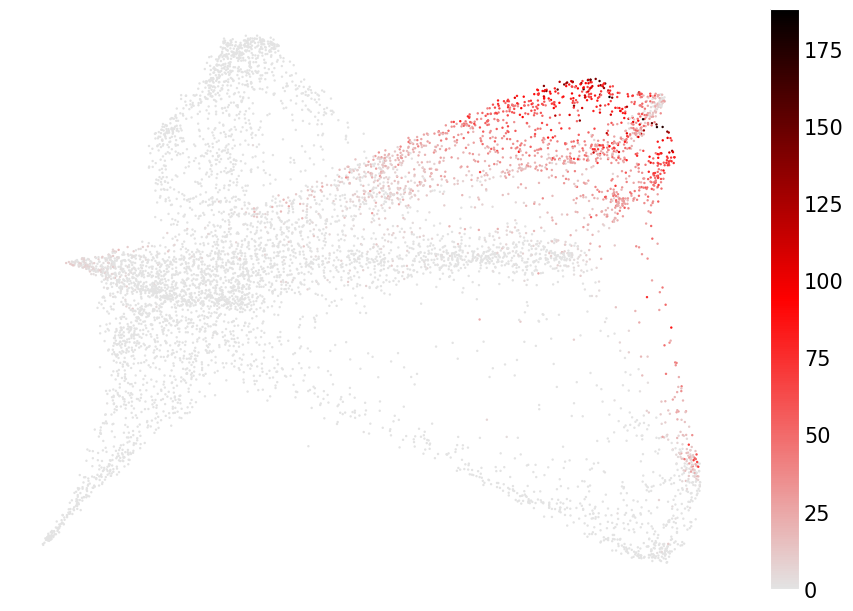

In [27]:
rna.obs['Krt71_t1'] = rna[:, 'Krt71'].X.toarray().flatten()

oci.pl.scatter(rna, x='X', c='Krt71_t1', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Plot the imputed gene expression of Krt73.

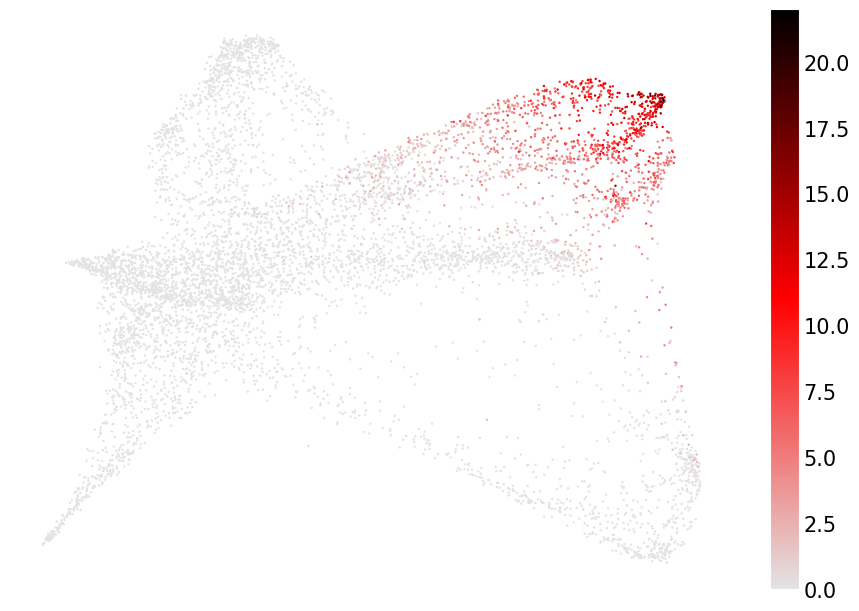

In [28]:
rna.obs['Krt73_t1'] = rna[:, 'Krt73'].X.toarray().flatten()

oci.pl.scatter(rna, x='X', c='Krt73_t1', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Ocelli's multimodal imputation successfully strengthened the signal of both sparse markers Krt71 and Krt73.

## Imputation of ATAC-seq peak activity

Repeat the above steps to impute the activity of Krt71 and Krt73 promoters. We found promoters of both markers using [GREAT](http://great.stanford.edu/great/public/html/).

In [29]:
promoters = {'Krt71': ['P_175393'], 'Krt73': ['P_337703']}

Load the raw promoter activity.

In [30]:
peaks = ad.read_h5ad('hair_follicle_atac_peaks.h5ad')[:, ['P_175393', 'P_337703']]
peaks.obsm['X'] = adata.obsm['X_proj']

Plot the raw activity of Krt71's promoter.

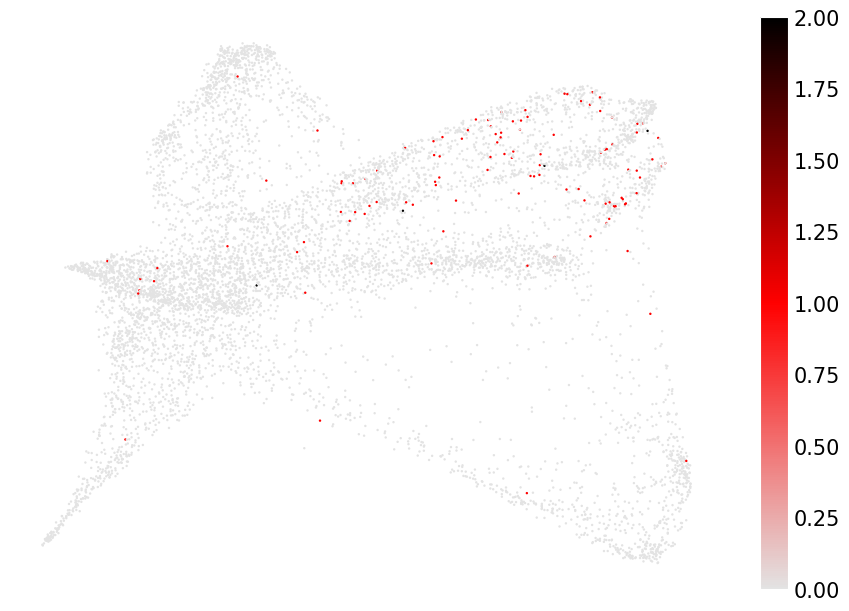

In [31]:
peaks.obs['Krt71_t0'] = peaks[:, promoters['Krt71']].X.toarray().flatten()

oci.pl.scatter(peaks, x='X', c='Krt71_t0', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Plot the raw activity of Krt73's promoter.

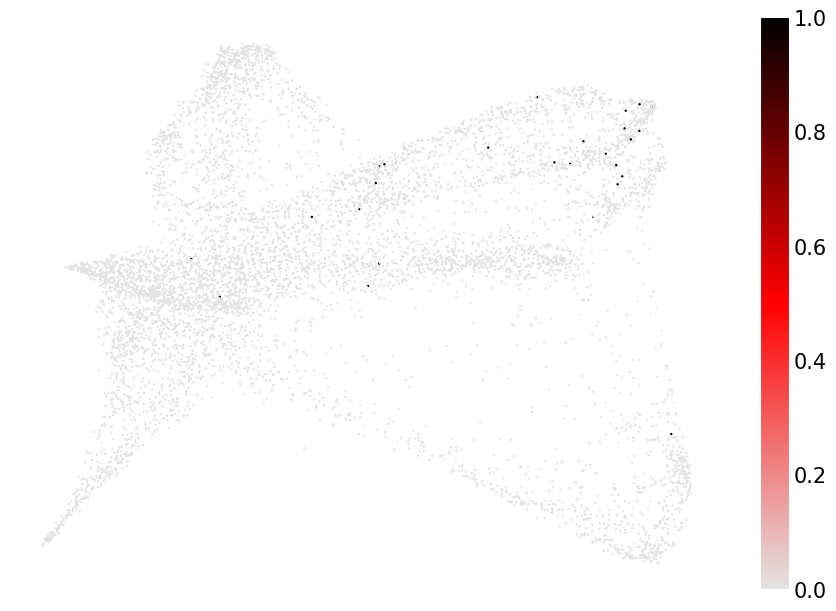

In [32]:
peaks.obs['Krt73_t0'] = peaks[:, promoters['Krt73']].X.toarray().flatten()

oci.pl.scatter(peaks, x='X', c='Krt73_t0', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Add eigenvectors and eigenvalues to the `peaks` obejct.

In [33]:
peaks.uns['eigenvalues'] = adata.uns['eigenvalues']
peaks.uns['eigenvectors'] = adata.uns['eigenvectors']

oci.tl.imputation(peaks, t=1)

Plot the imputed activity of Krt71's promoter.

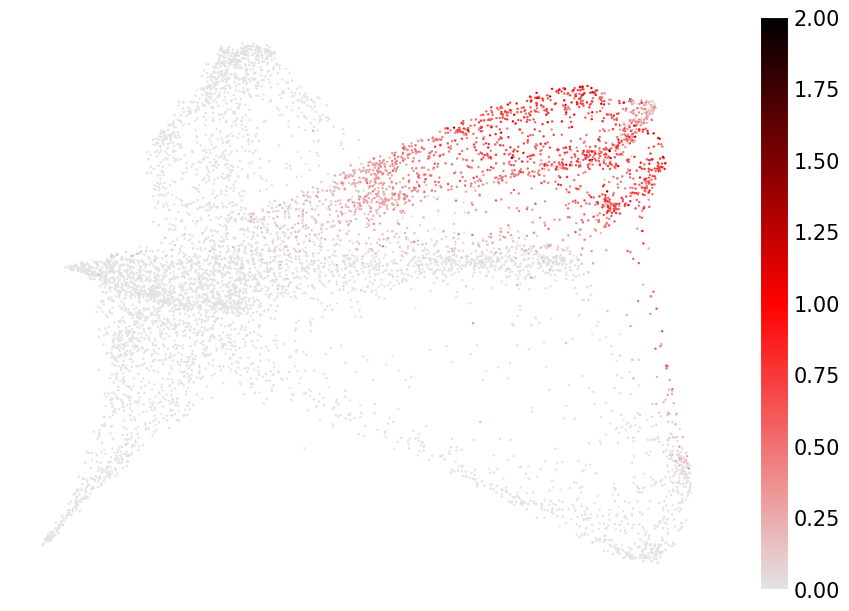

In [34]:
peaks.obs['Krt71_t1'] = peaks[:, promoters['Krt71']].X.toarray().flatten()

oci.pl.scatter(peaks, x='X', c='Krt71_t1', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Plot the imputed activity of Krt73's promoter.

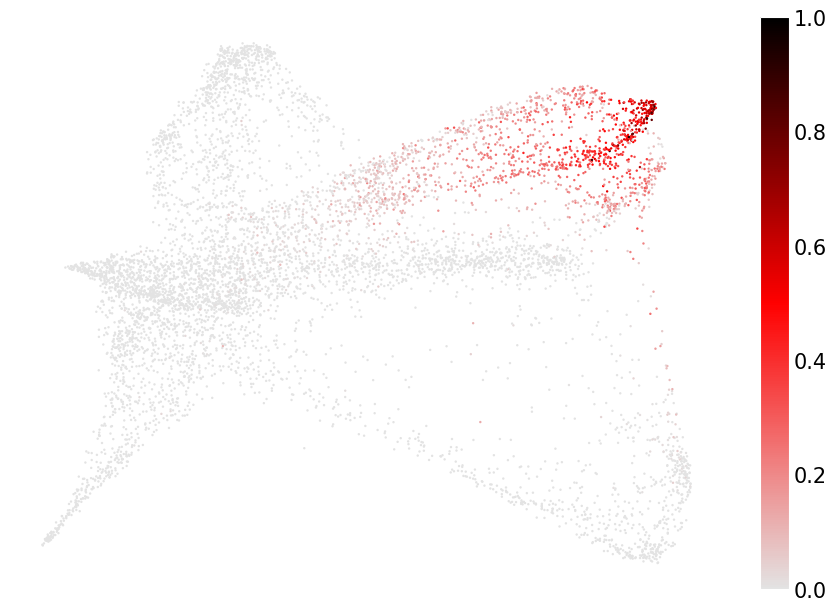

In [35]:
peaks.obs['Krt73_t1'] = peaks[:, promoters['Krt73']].X.toarray().flatten()

oci.pl.scatter(peaks, x='X', c='Krt73_t1', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Ocelli successfully imputed values of highly sparse promoter activity.

Investigation of diffusion-based multimodal imputation concludes Tutorial 2. In Tutorial 3, you will explore a bimodal single-cell dataset of human bone marrow.